In [11]:
import os

# 1. Make the directory expected by Kaggle
os.makedirs('/root/.kaggle', exist_ok=True)

# 2. Move the uploaded kaggle.json file to that directory
# (Assuming you uploaded it to the default /content folder)
!mv /content/kaggle.json /root/.kaggle/

# 3. Set permissions so only you can read it (required by Kaggle)
!chmod 600 /root/.kaggle/kaggle.json

print("Kaggle API key setup complete!")

mv: cannot stat '/content/kaggle.json': No such file or directory
Kaggle API key setup complete!


In [12]:
#!/bin/bash
!kaggle datasets download shaunthesheep/microsoft-catsvsdogs-dataset

Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset
License(s): other
 82% 648M/788M [00:10<00:03, 41.3MB/s]
100% 788M/788M [00:10<00:00, 77.0MB/s]


In [22]:
import zipfile

with zipfile.ZipFile("/content/microsoft-catsvsdogs-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")
    zip_ref.close()

In [23]:
import os
from PIL import Image

# Define your dataset path
dataset_dir = '/content/PetImages'
extensions = ['jpg', 'jpeg', 'png', 'bmp', 'gif']

# Walk through all folders
for root, dirs, files in os.walk(dataset_dir):
    for filename in files:
        file_path = os.path.join(root, filename)

        try:
            # 1. Check if file is empty (0 bytes)
            if os.path.getsize(file_path) == 0:
                print(f"Deleting empty file: {file_path}")
                os.remove(file_path)
                continue

            # 2. Check if file is a valid image using PIL
            # Only check files with image extensions
            if any(filename.lower().endswith(ext) for ext in extensions):
                try:
                    img = Image.open(file_path)
                    img.verify() # Verify integrity
                    img.close()
                    # Re-open to check if it can actually be loaded (verify() doesn't catch everything)
                    img = Image.open(file_path)
                    img.load()
                    img.close()
                except (IOError, SyntaxError) as e:
                    print(f"Deleting corrupt image: {file_path} - Error: {e}")
                    os.remove(file_path)

        except Exception as e:
            print(f"Error checking file {file_path}: {e}")

print("Cleanup complete! You can now run your dataset generators.")

Deleting empty file: /content/PetImages/Cat/666.jpg
Deleting empty file: /content/PetImages/Dog/11702.jpg


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Cleanup complete! You can now run your dataset generators.


In [39]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D , BatchNormalization, Dropout
from tensorflow.keras.models import Sequential


In [31]:
import os
import tensorflow as tf

# Define your dataset path
data_dir = '/content/PetImages'

print("Starting strict cleanup... this may take a minute.")

# Walk through all folders
for root, dirs, files in os.walk(data_dir):
    for filename in files:
        file_path = os.path.join(root, filename)

        # specific check for the common corrupted file
        if filename == "666.jpg":
             print(f"Found known bad file {filename}... Removing.")
             os.remove(file_path)
             continue

        try:
            # Load the file as raw bytes
            img_bytes = tf.io.read_file(file_path)

            # Force TensorFlow to decode it (this is where it catches the error)
            # We use expand_animations=False to handle all formats safely
            img = tf.io.decode_image(img_bytes, channels=3, expand_animations=False)

        except tf.errors.InvalidArgumentError as e:
            print(f"Deleting corrupt image (TF rejected): {file_path}")
            os.remove(file_path)
        except Exception as e:
            print(f"Deleting error file: {file_path}")
            os.remove(file_path)

print("Strict cleanup complete.")

Starting strict cleanup... this may take a minute.
Deleting corrupt image (TF rejected): /content/PetImages/Cat/Thumbs.db
Deleting corrupt image (TF rejected): /content/PetImages/Cat/10404.jpg
Deleting corrupt image (TF rejected): /content/PetImages/Cat/4351.jpg
Deleting corrupt image (TF rejected): /content/PetImages/Dog/Thumbs.db
Found known bad file 666.jpg... Removing.
Deleting corrupt image (TF rejected): /content/PetImages/Dog/2494.jpg
Deleting corrupt image (TF rejected): /content/PetImages/Dog/11912.jpg
Deleting corrupt image (TF rejected): /content/PetImages/Dog/9500.jpg
Deleting corrupt image (TF rejected): /content/PetImages/Dog/2317.jpg
Deleting corrupt image (TF rejected): /content/PetImages/Dog/11233.jpg
Strict cleanup complete.


In [32]:


# Define the path to your single dataset folder
data_dir = '/content/PetImages'  # Make sure this matches your path

# 1. Create the TRAINING set (e.g., use 80% of the images)
train_dataset = keras.utils.image_dataset_from_directory(
    directory = data_dir,
    image_size = (256, 256),
    batch_size = 32,
    labels = 'inferred',
    label_mode = 'int',
    validation_split = 0.2,  # Tell Keras to reserve 20% for testing
    subset = 'training',     # "Give me the 80% for training"
    seed = 123               # IMPORTANT: Seed must be same for both!
)

# 2. Create the TESTING (Validation) set (e.g., use the remaining 20%)
test_dataset = keras.utils.image_dataset_from_directory(
    directory = data_dir,
    image_size = (256, 256),
    batch_size = 32,
    labels = 'inferred',
    label_mode = 'int',
    validation_split = 0.2,  # Same split size
    subset = 'validation',   # "Give me the 20% for testing"
    seed = 123               # IMPORTANT: Must match train_dataset seed!
)

Found 24990 files belonging to 2 classes.
Using 19992 files for training.
Found 24990 files belonging to 2 classes.
Using 4998 files for validation.


In [33]:
#Normalize
def process(image , label):
  image = tf.cast(image/255 , tf.float32)
  return image , label

train_dataset = train_dataset.map(process)
validation_dataset = test_dataset.map(process)


In [40]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),padding="valid",activation="relu",input_shape=(256, 256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides = 2, padding = "valid"))

model.add(Conv2D(64, kernel_size=(3, 3),padding="valid",activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides = 2, padding = "valid"))

model.add(Conv2D(128, kernel_size=(3, 3),padding="valid",activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides = 2, padding = "valid"))

model.add(Flatten())

model.add(Dense(128,activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(64,activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1,activation="sigmoid"))
#

In [41]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [42]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [43]:
history = model.fit(train_dataset , epochs = 10 , validation_data=validation_dataset )

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 77s 112ms/step - accuracy: 0.5753 - loss: 2.6047 - val_accuracy: 0.6126 - val_loss: 0.6441
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 89ms/step - accuracy: 0.6898 - loss: 0.5866 - val_accuracy: 0.7191 - val_loss: 0.5394
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.7555 - loss: 0.5048 - val_accuracy: 0.7365 - val_loss: 0.5083
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 88ms/step - accuracy: 0.7881 - loss: 0.4635 - val_accuracy: 0.7235 - val_loss: 0.5295
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 87ms/step - accuracy: 0.8264 - loss: 0.3844 - val_accuracy: 0.8189 - val_loss: 0.4097
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 89ms/step - accuracy: 0.8591 - loss: 0.3229 - val_accuracy: 0.7543 - val_loss: 0.7605
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 87ms/step - accuracy: 0.8950 - loss: 0.2501 - val_accuracy: 0.7645 - val_loss: 0.8268
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 88ms/step - accuracy: 0.9256 - loss: 0.1762 -

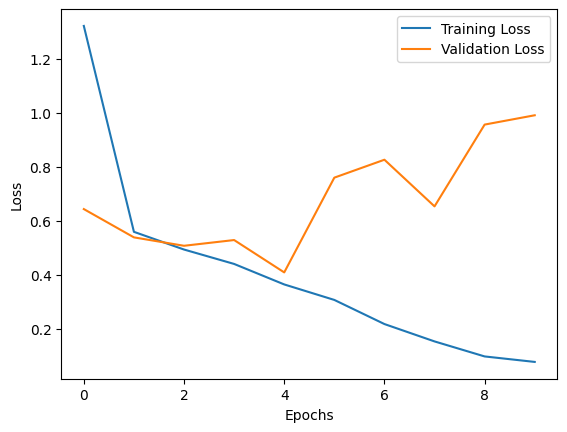

In [44]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [46]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,          # "If val_loss doesn't improve for 3 epochs..."
    restore_best_weights=True # "...stop and go back to the best epoch."
)

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=[early_stopping] # Add the callback here
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 88ms/step - accuracy: 0.9823 - loss: 0.0510 - val_accuracy: 0.8293 - val_loss: 0.6749
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 93ms/step - accuracy: 0.9849 - loss: 0.0436 - val_accuracy: 0.8363 - val_loss: 0.9294
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - accuracy: 0.9848 - loss: 0.0440 - val_accuracy: 0.7999 - val_loss: 0.7813
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 88ms/step - accuracy: 0.9899 - loss: 0.0305 - val_accuracy: 0.8245 - val_loss: 1.1344


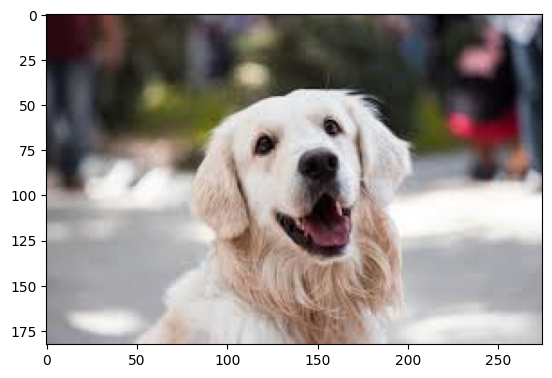

In [58]:
import cv2
import matplotlib.pyplot as plt

test_img = cv2.imread('/content/dog1.jfif')
# Convert BGR to RGB for matplotlib display
test_img_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

plt.imshow(test_img_rgb)
plt.show()

In [59]:
test_img.shape

(183, 275, 3)

In [60]:
test_img = cv2.resize(test_img, (256, 256))
test_input = test_img.reshape( (1, 256, 256, 3))
model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


array([[1.]], dtype=float32)